In [3]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from operator import add
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import sparknlp
from sparknlp.annotator import LemmatizerModel
from sparknlp.pretrained import PretrainedPipeline
spark = sparknlp.start()

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from nltk import pos_tag

In [5]:
import pandas as pd

In [6]:
#spark = SparkSession\
 #   .builder \
  #  .appName("PythonWordCount") \
   # .appName("Spark NLP")\
    #.master("local[*]")\
#    .config("spark.driver.memory","16G")\
 #   .config("spark.driver.maxResultSize", "0") \
  #  .config("spark.kryoserializer.buffer.max", "2000M")\
   # .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.0.1")\
    #.getOrCreate()
SparkSession.builder.config("spark.jars", "hdfs://somepath/sparknlp.jar")    

In [7]:
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,
                                LemmatizerModel, StopWordsCleaner)
from pyspark.ml import Pipeline

In [8]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import udf, concat, col, lit
import re
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt

In [9]:
hacker = spark.read.format('csv').options(header='true', inferSchema='true') \
    .load('/spring2021/project1/hacker_news_sample.csv')

In [10]:
blog =spark.read.format('csv').options(header='true', inferSchema='true') \
    .load('/spring2021/project1/blogtext.csv')

In [11]:
blog = blog.na.drop(subset=["text"])

In [12]:
hacker = hacker.na.drop(subset=["text"])

In [13]:
hacker.show()

+---------------+----+--------------------+----+---------------+-----+----------+-------+--------+--------+-----------+-------+-------+-------------------+
|          title| url|                text|dead|             by|score|      time|   type|      id|  parent|descendants|ranking|deleted|          timestamp|
+---------------+----+--------------------+----+---------------+-----+----------+-------+--------+--------+-----------+-------+-------+-------------------+
|           null|null|&gt;<i>which lead...|null|        coldtea| null|1390843873|comment| 7131680| 7127578|       null|   null|   null|2014-01-27 12:31:13|
|           null|null|I would like to p...|null|         etanol| null|1319395600|comment| 3146879| 3145330|       null|   null|   null|2011-10-23 14:46:40|
|           null|null|<i>Our msbuild im...|null|      Locke1689| null|1407881590|comment| 8170491| 8170071|       null|   null|   null|2014-08-12 18:13:10|
|           null|null|No matter how awf...|null|    miloshadzic|

In [14]:
blog.withColumn('word', f.explode(f.split(f.col('text'), ' '))) \
    .groupBy('word') \
    .count() \
    .sort('count', ascending=False) \
    .show()

+----+--------+
|word|   count|
+----+--------+
|    |21947071|
| the| 4785813|
|  to| 3842686|
|   I| 3546824|
| and| 3303462|
|   a| 2750098|
|  of| 2362880|
|  in| 1600813|
|that| 1540793|
|  is| 1318969|
|  my| 1300203|
| was| 1142040|
| for| 1136815|
|  it| 1095818|
| you|  968555|
|   i|  889681|
|  on|  883373|
|have|  817514|
|with|  816734|
|  be|  740803|
+----+--------+
only showing top 20 rows



In [15]:
hacker.withColumn('word', f.explode(f.split(f.col('text'), ' '))) \
    .groupBy('word') \
    .count() \
    .sort('count', ascending=False) \
    .show()

+----+------+
|word| count|
+----+------+
| the|346807|
|  to|260578|
|   a|224952|
|  of|186141|
| and|170948|
|  is|145182|
|that|132135|
|   I|121470|
|  in|113588|
| you| 89622|
| for| 89295|
|  it| 87574|
|    | 64798|
|  be| 63524|
|  on| 61459|
| are| 60230|
|with| 59479|
|have| 56174|
| not| 55318|
| but| 49318|
+----+------+
only showing top 20 rows



In [16]:
tokenizer = Tokenizer(inputCol="text", outputCol="words_token")
tokenized = tokenizer.transform(hacker).select('text','words_token')
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="words_token")
regexTokenized = regexTokenizer.transform(hacker).select('words_token')
regexTokenized.show()

+--------------------+
|         words_token|
+--------------------+
|[&gt;<i>which, le...|
|[i, would, like, ...|
|[<i>our, msbuild,...|
|[no, matter, how,...|
|[the, existence, ...|
|[the, actual, int...|
|[i, want, to, kno...|
|[french, is, supr...|
|[i, actually, wen...|
|[first, impressio...|
|[it&#x27;s, not, ...|
|[thanks., i, choo...|
|[i, used, sybase,...|
|[&gt;they&#x27;ve...|
|[if, there's, a, ...|
|[(i, submitted, t...|
|["actually, the, ...|
|[&#62;, if, the, ...|
|[looks, like, the...|
|[definitely, has,...|
+--------------------+
only showing top 20 rows



In [17]:
regex_blog = regexTokenizer.transform(blog).select('words_token')
regex_blog.show()

+--------------------+
|         words_token|
+--------------------+
|[info, has, been,...|
|[these, are, the,...|
|[in, het, kader, ...|
|[testing!!!, test...|
|[thanks, to, yaho...|
|[i, had, an, inte...|
|[somehow, coca-co...|
|[if, anything,, k...|
|[take, a, read, o...|
|[i, surf, the, en...|
|[ah,, the, korean...|
|[if, you, click, ...|
|[last, night, was...|
|[there, is, so, m...|
|[urllink, here, i...|
|[one, thing, i, l...|
|[urllink, wonderf...|
|[here, is, the, l...|
|[well,, i, stand,...|
|[so, i've, been, ...|
+--------------------+
only showing top 20 rows



In [18]:
remover_blog = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
clean_blog = remover_blog.transform(regex_blog).select( 'words_clean')
clean_blog.show()

+--------------------+
|         words_clean|
+--------------------+
|[info, found, (+/...|
|[team, members:, ...|
|[het, kader, van,...|
|[testing!!!, test...|
|[thanks, yahoo!'s...|
|[interesting, con...|
|[somehow, coca-co...|
|[anything,, korea...|
|[take, read, news...|
|[surf, english, n...|
|[ah,, korean, lan...|
|[click, profile, ...|
|[last, night, pre...|
|[much, different,...|
|[urllink, is,, su...|
|[one, thing, love...|
|[urllink, wonderf...|
|[latest, korean, ...|
|[well,, stand, co...|
|[vancouver, days,...|
+--------------------+
only showing top 20 rows



In [19]:
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
data_cleaning = remover.transform(regexTokenized).select( 'words_clean')
data_cleaning.show()

+--------------------+
|         words_clean|
+--------------------+
|[&gt;<i>which, le...|
|[like, point, cou...|
|[<i>our, msbuild,...|
|[matter, awful, i...|
|[existence, way, ...|
|[actual, internet...|
|[want, know, ants...|
|[french, supremel...|
|[actually, went, ...|
|[first, impressio...|
|[it&#x27;s, exact...|
|[thanks., choose,...|
|[used, sybase, as...|
|[&gt;they&#x27;ve...|
|[high, chance, go...|
|[(i, submitted, d...|
|["actually, defin...|
|[&#62;, applicati...|
|[looks, like, 10k...|
|[definitely, slan...|
+--------------------+
only showing top 20 rows



In [20]:
result = data_cleaning.withColumn('word', f.explode(f.col('words_clean'))) \
    .groupBy('word') \
    .count().sort('count', ascending=False) \


In [21]:
blog_result = clean_blog.withColumn('word', f.explode(f.col('words_clean'))) \
    .groupBy('word') \
    .count().sort('count', ascending=False) \

In [22]:
blog_result.show()

+-------+------+
|   word| count|
+-------+------+
|   like|518688|
|    one|392588|
|    get|384211|
|urllink|383212|
| really|304997|
|   know|293736|
|  think|273851|
|      -|271564|
|     go|271412|
|    got|260760|
|   time|248363|
|  going|238229|
| people|229895|
|   good|219236|
|   back|204577|
|    see|202232|
|   want|190427|
|   even|186300|
|   much|186168|
|   went|182800|
+-------+------+
only showing top 20 rows



In [23]:
searchfor = ['fuck', 'fucking', 'damn', 'shit','hell','dick']
check_udf = f.udf(lambda x: x if x in searchfor else 'Not_present')

df = result.withColumn('check_presence', check_udf(f.col('word')))
profrane = df.filter(df.check_presence != 'Not_present').drop('check_presence')

In [24]:
profrane.show()

+-------+-----+
|   word|count|
+-------+-----+
|   hell|  675|
|   shit|  523|
|   damn|  384|
|   fuck|  254|
|fucking|  226|
|   dick|   71|
+-------+-----+



In [25]:
searchfor_blog = ['fuck', 'fucking', 'damn', 'shit','hell','dick']
check_udfblog = f.udf(lambda x: x if x in searchfor_blog else 'Not_present')

df_blog = blog_result.withColumn('check_presence', check_udfblog(f.col('word')))
profrane_blog = df_blog.filter(df_blog.check_presence != 'Not_present').drop('check_presence')

In [26]:
profrane_blog.show()

+-------+-----+
|   word|count|
+-------+-----+
|   damn|31990|
|fucking|30173|
|   hell|29258|
|   shit|25853|
|   fuck|21072|
|   dick| 3104|
+-------+-----+



In [27]:
bad_words =profrane_blog.toPandas()


In [28]:
profanity =profrane.toPandas()

In [29]:
profanity.head() #hacker profanity chart

,word,count
0,hell,675
1,shit,523
2,damn,384
3,fuck,254
4,fucking,226


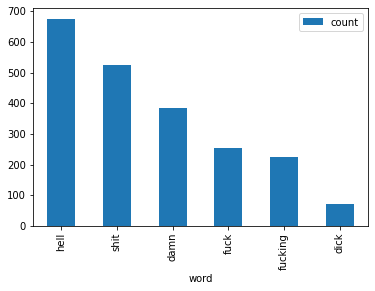

In [30]:
profrane_graph = profanity.plot.bar(x= 'word',y='count')

In [31]:
df_both = pd.merge(profanity, bad_words, on='word')

df_both.columns=['word','Hacker','Blog']
df_both.head()

,word,Hacker,Blog
0,hell,675,29258
1,shit,523,25853
2,damn,384,31990
3,fuck,254,21072
4,fucking,226,30173


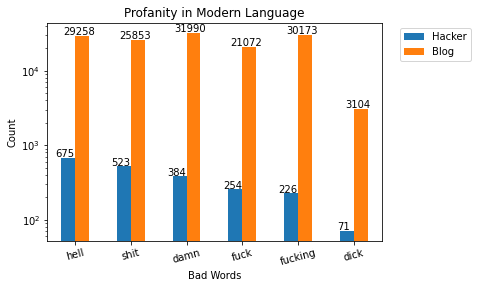

In [32]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#index = ['fuck', 'fucking', 'damn', 'shit','hell','dick']

ax = df_both.plot.bar(x='word', logy=True,rot=15)

#plt.xticks('word')
plt.ylabel("Count")
plt.xlabel("Bad Words")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title("Profanity in Modern Language")

hacky = df_both.reset_index() 
blogy = df_both.reset_index() 

valss = pd.concat([hacky.Hacker, blogy.Blog], axis=1)
vals =valss.unstack().reset_index(level=[0,1], drop=True)



for idx, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/3.5,
            height + height*.02,
            vals[idx],
            ha="center")


In [33]:
hackernew=data_cleaning.toPandas()

In [34]:
blognew= clean_blog.toPandas()

In [35]:
hacking = result.toPandas()

hacking.head(20)

,word,count
0,like,31676
1,people,28749
2,one,22442
3,think,21404
4,it&#x27;s,20890
5,get,20059
6,use,15903
7,even,15826
8,-,15537
9,much,15440


In [36]:
hackernew.head()

,words_clean
0,"[&gt;<i>which, leads, say, using, c, x?</i><p>..."
1,"[like, point, counter-examples:<p>«<i>think, j..."
2,"[<i>our, msbuild, implementation, build, proje..."
3,"[matter, awful, iphoto, still, better, almost,..."
4,"[existence, way, shard, searches, make, scalin..."


In [37]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(text))
    text = re.sub('\[.*?\]', '', str(text))
    text = re.sub('\w*\d\w*', '', str(text))
    return text

round1 = lambda x: clean_text_round1(x)

In [38]:
blogger_clean = pd.DataFrame(blognew.words_clean.apply(round1))

In [39]:
data_clean = pd.DataFrame(hackernew.words_clean.apply(round1))

data_clean

,words_clean
0,gt i which leads say using c ...
1,like point counter examples p i thi...
2,i our msbuild implementation build...
3,matter awful iphoto still better...
4,existence way shard searches mak...
...,...
162138,oh wow didn x t notice settin...
162139,using weeks think rocks great...
162140,matters p reads hn works ...
162141,it x s giving up it x s e...


In [40]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text
round2 = lambda x: clean_text_round2(x)

In [41]:
blogger_clean2 = pd.DataFrame(blogger_clean.words_clean.apply(round2))
blogger_clean2

,words_clean
0,info found pages ...
1,team members drewes van der ...
2,het kader van kernfusie op aa...
3,testing testing
4,thanks yahoo s toolbar capture ...
...,...
681279,dear susan write really bitter ...
681280,dear susan i second yeast i...
681281,dear susan boyfriend fucking ...
681282,dear susan clarify asking leav...


In [42]:
data_clean2 = pd.DataFrame(data_clean.words_clean.apply(round2))
data_clean2

,words_clean
0,gt i which leads say using c ...
1,like point counter examples p i thi...
2,i our msbuild implementation build...
3,matter awful iphoto still better...
4,existence way shard searches mak...
...,...
162138,oh wow didn x t notice settin...
162139,using weeks think rocks great...
162140,matters p reads hn works ...
162141,it x s giving up it x s e...


In [45]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean2.words_clean)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean2.index
data_dtm

,aa,aaa,aaaa,aaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaai,aaaaaaaaarw,aaaaaaaaau,aaaaaaaaaum,aaaaaaaaav,...,zyxo,zz,zzbrs,zziar,zzk,zzleeper,zztthyho,zzyryya,zzz,zzzcpan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [276]:
data = data_dtm.transpose()



In [47]:
from collections import Counter

In [200]:
new = spark.createDataFrame(data_clean)
newblog=spark.createDataFrame(blogger_clean2)

In [201]:
tokener = RegexTokenizer(inputCol="words_clean", outputCol="text")
tokened = tokener.transform(new).select('text')


blogtokened = tokener.transform(newblog).select('text')

In [50]:
tokened.show()

+--------------------+
|                text|
+--------------------+
|[gt, i, which, le...|
|[like, point, cou...|
|[i, our, msbuild,...|
|[matter, awful, i...|
|[existence, way, ...|
|[actual, internet...|
|[want, know, ants...|
|[french, supremel...|
|[actually, went, ...|
|[first, impressio...|
|[it, x, s, exactl...|
|[thanks, choose, ...|
|[used, sybase, as...|
|[gt, they, x, ve,...|
|[high, chance, go...|
|[i, submitted, da...|
|[actually, defini...|
|[application, bec...|
|[looks, like, k, ...|
|[definitely, slan...|
+--------------------+
only showing top 20 rows



In [202]:
hack = tokened.toPandas()
bloggers= blogtokened.toPandas()

In [203]:
bloggers

,text
0,"[info, found, pages, mb, pdf, files, wait, unt..."
1,"[team, members, drewes, van, der, laag, urllin..."
2,"[het, kader, van, kernfusie, op, aarde, maak, ..."
3,"[testing, testing]"
4,"[thanks, yahoo, s, toolbar, capture, urls, pop..."
...,...
681279,"[dear, susan, write, really, bitter, diatribe,..."
681280,"[dear, susan, i, second, yeast, infection, pas..."
681281,"[dear, susan, boyfriend, fucking, bald, good, ..."
681282,"[dear, susan, clarify, asking, leave, house, w..."


In [52]:
full_list = []  # list containing all words of all texts
for elmnt in hackernew['words_clean']:  # loop over lists in df
    full_list += elmnt  # append elements of lists to full list

val_counts = pd.Series(full_list).value_counts()

In [203]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    #toke = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(text) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [54]:
data_nouns_adj = pd.DataFrame(hack.text.apply(nouns_adj))
#hacker

In [204]:
blog_nouns_adj = pd.DataFrame(bloggers.text.apply(nouns_adj))


In [240]:
blog_nouns=spark.createDataFrame(blog_nouns_adj)

In [248]:
tokes = RegexTokenizer(inputCol="text", outputCol="texts")



blog_nouns_tokened = tokes.transform(blog_nouns).select('texts')

In [253]:
bloggernouns = blog_nouns_tokened.withColumn('word', f.explode(f.col('texts'))) \
    .groupBy('word') \
    .count().sort('count', ascending=False) \

blog_df=bloggernouns.toPandas()

In [271]:
blog_dfs=blog_df.head(200000)

print(blog_dfs)

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [55]:
data_nouns_adj

,text
0,gt i c x i s fast lots available java cl p eng...
1,point counter i journalists many jobs newspape...
2,msbuild implementation build project i impress...
3,matter awful iphoto anything find linux bigges...
4,existence way shard searches real time search ...
...,...
162138,wow didn x t notice settings top bar thanks
162139,weeks rocks great way aggregate friend feeds web
162140,matters reads works bootcamp different p reads...
162141,s x set risks reward question feels risks ill ...


In [63]:
from sklearn.feature_extraction import text
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said','http','href','www','gt','quot',]
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [273]:
cvna_blog = CountVectorizer(stop_words=stop_words)
data_cvna_blog = cvna_blog.fit_transform(blog_nouns_adj.text)

In [275]:
data_dtmna_blog = pd.DataFrame(data_cvna_blog.toarray(), columns=cvna_blog.get_feature_names())
data_dtmna_blog.index =blog_nouns_adj.index
data_dtmna_blog

MemoryError: Unable to allocate 2.67 TiB for an array with shape (681284, 538690) and data type int64

In [64]:
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.text)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna

,aa,aaa,aaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaai,aaaaaaaaarw,aaaaaaaaau,aaaaaaaabio,aaaaaaaack,aaaaaaaacky,...,zyxo,zz,zzbrs,zziar,zzk,zzleeper,zztthyho,zzyryya,zzz,zzzcpan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
162141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
from gensim import matutils, models
import scipy.sparse


In [65]:
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [115]:
import nltk

In [67]:
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.017*"wikipedia" + 0.017*"wiki" + 0.016*"org" + 0.014*"apple" + 0.009*"phone" + 0.008*"linux" + 0.008*"software" + 0.007*"windows" + 0.007*"game" + 0.006*"microsoft"'),
 (1,
  '0.009*"good" + 0.008*"code" + 0.008*"way" + 0.007*"things" + 0.006*"use" + 0.006*"point" + 0.006*"problem" + 0.006*"work" + 0.005*"thing" + 0.005*"different"'),
 (2,
  '0.052*"com" + 0.039*"nofollow" + 0.039*"rel" + 0.029*"https" + 0.011*"news" + 0.011*"google" + 0.009*"web" + 0.008*"org" + 0.008*"site" + 0.007*"app"'),
 (3,
  '0.007*"money" + 0.007*"company" + 0.006*"good" + 0.005*"business" + 0.005*"way" + 0.005*"work" + 0.005*"years" + 0.005*"companies" + 0.004*"market" + 0.004*"don"')]

In [68]:
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=80)
ldana.print_topics()

[(0,
  '0.009*"money" + 0.006*"market" + 0.005*"government" + 0.005*"cost" + 0.004*"power" + 0.004*"companies" + 0.004*"law" + 0.004*"business" + 0.004*"free" + 0.004*"price"'),
 (1,
  '0.011*"good" + 0.008*"work" + 0.007*"way" + 0.007*"things" + 0.005*"point" + 0.005*"thing" + 0.005*"years" + 0.005*"don" + 0.005*"lot" + 0.005*"company"'),
 (2,
  '0.012*"code" + 0.011*"use" + 0.008*"data" + 0.006*"language" + 0.005*"way" + 0.005*"new" + 0.005*"web" + 0.005*"software" + 0.004*"user" + 0.004*"users"'),
 (3,
  '0.071*"com" + 0.054*"nofollow" + 0.054*"rel" + 0.041*"https" + 0.025*"org" + 0.019*"google" + 0.016*"news" + 0.014*"wikipedia" + 0.014*"wiki" + 0.012*"apple"')]

In [ ]:
#Anaylzing Books

In [43]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

spark = SparkSession.builder\
    .master("local[*]")\
    .appName("Spark_word_count")\
    .getOrCreate()

sc = spark.sparkContext

In [44]:
pride_spark = spark.read.text("/spring2021/project1/ddss/PrideClean.txt")
moby_spark = spark.read.text("/spring2021/project1/ddss/MobyCleanChaptersOnly.txt")
gatsby_spark = spark.read.text("/spring2021/project1/ddss/GatsbyClean.txt")


pride_pd = pride_spark.toPandas()
moby_pd = moby_spark.toPandas()
gatsby_pd= gatsby_spark.toPandas()

In [45]:
pride_clean = pd.DataFrame(pride_pd.value.apply(round1))
moby_clean = pd.DataFrame(moby_pd.value.apply(round1))
gatsby_clean = pd.DataFrame(gatsby_pd.value.apply(round1))

pride_clean = pd.DataFrame(pride_clean.value.apply(round2))
moby_clean = pd.DataFrame(moby_clean.value.apply(round2))
gatsby_clean = pd.DataFrame(gatsby_clean.value.apply(round2))

In [46]:
pride_df = spark.createDataFrame(pride_clean)
moby_df = spark.createDataFrame(moby_clean)
gatsby_df= spark.createDataFrame(gatsby_clean)

In [47]:
tokener_text = RegexTokenizer(inputCol="value", outputCol="text")
pride_tokened = tokener_text.transform(pride_df).select('text')


moby_tokened = tokener_text.transform(moby_df).select('text')
gatsby_tokened = tokener_text.transform(gatsby_df).select('text')

In [48]:
remover_book = StopWordsRemover(inputCol='text', outputCol='words_clean')
pridedf = remover_book.transform(pride_tokened).select( 'words_clean')

mobydf= remover_book.transform(moby_tokened).select( 'words_clean')

gatsbydf = remover_book.transform(gatsby_tokened).select( 'words_clean')

In [49]:
mobyful = mobydf.toPandas()
prideful = pridedf.toPandas()
gatsful = gatsbydf.toPandas()

In [50]:
prider = pride_tokened.withColumn('word', f.explode(f.col('text'))) \
    .groupBy('word') \
    .count().sort('count', ascending=False) \

mobyr = moby_tokened.withColumn('word', f.explode(f.col('text'))) \
    .groupBy('word') \
    .count().sort('count', ascending=False) \

gatsbyr = gatsby_tokened.withColumn('word', f.explode(f.col('text'))) \
    .groupBy('word') \
    .count().sort('count', ascending=False) \

In [51]:
searchfor_text = ['fuck', 'fucking', 'damn', 'shit','hell','dick','pussy']
check_udf = f.udf(lambda x: x if x in searchfor_text else 'Not_present')

df_pride = prider.withColumn('check_presence', check_udf(f.col('word')))
pride_curse = df_pride.filter(df_pride.check_presence != 'Not_present').drop('check_presence')

df_moby = mobyr.withColumn('check_presence', check_udf(f.col('word')))
moby_curse = df_moby.filter(df_moby.check_presence != 'Not_present').drop('check_presence')

df_gatsby = gatsbyr.withColumn('check_presence', check_udf(f.col('word')))
gatsby_curse = df_gatsby.filter(df_gatsby.check_presence != 'Not_present').drop('check_presence')



In [52]:
pride_profane = pride_curse.toPandas()

moby_profane = moby_curse.toPandas()

gatsby_profane=gatsby_curse.toPandas()

In [104]:
gatsby_profane.head()

,word,count
0,hell,3
1,damn,3


In [56]:
books = pd.merge(moby_profane,gatsby_profane, on='word')

books.columns=['word','Moby', 'Gatsby']

In [72]:
word_added = {'word': 'dick', 'Moby':83, 'Gatsby': 0}
books = books.append(word_added, ignore_index = True)


In [78]:
books = books.drop([3,4,5])

In [79]:

books

,word,Moby,Gatsby
0,hell,16,3
1,damn,9,3
2,dick,83,0


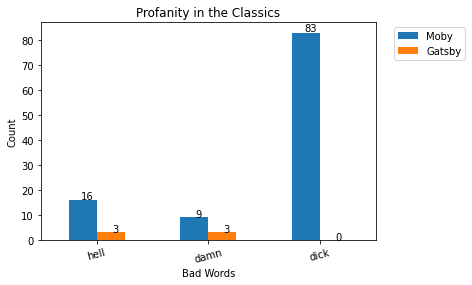

In [80]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
#index = ['hell','dick',damn]

ax1 = books.plot.bar(x='word', logy=False,rot=15)

#plt.xticks('word')
plt.ylabel("Count")
plt.xlabel("Bad Words")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title("Profanity in the Classics")



mob = books.reset_index() 
gat = books.reset_index() 

valss = pd.concat([mob.Moby, gat.Gatsby], axis=1)
vals =valss.unstack().reset_index(level=[0,1], drop=True)




for idx, p in enumerate(ax1.patches):
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/1.5,
            height + height*.007,
            vals[idx],
            ha="center")
            #color = 'o','g' )

In [81]:
# Sentiment Analysis

In [86]:
from textblob import TextBlob

In [87]:
def senti(x):
    return TextBlob(x).sentiment 

In [88]:
data_clean2['sentiment_score'] = data_clean2['words_clean'].apply(senti)

In [89]:
blogger_clean2['sentiment_score'] = blogger_clean2['words_clean'].apply(senti)


In [90]:
def clean_text_round3(text):
    text = re.sub('\[]','', str(text))
    return text
round3 = lambda x: clean_text_round3(x)

In [91]:
prideful = pd.DataFrame(prideful.words_clean.apply(round3))
mobyful = pd.DataFrame(mobyful.words_clean.apply(round3))
gatsful = pd.DataFrame(gatsful.words_clean.apply(round3))

In [92]:
prideful['sentiment_score'] = prideful['words_clean'].apply(senti)
mobyful['sentiment_score'] = mobyful['words_clean'].apply(senti)
gatsful['sentiment_score'] = gatsful['words_clean'].apply(senti)

In [99]:
from afinn import Afinn
from nltk import corpus
from nltk.corpus import words
import nltk
nltk.download('words')
af = Afinn()

[nltk_data] Downloading package words to /home/dbanks/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [103]:
data_clean2.groupby(by=['words_clean']).describe()

polarity                                    subjectivity       \
                count mean  std  min  25%  50%  75%  max        count mean   
words_clean                                                                  
                 44.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         44.0  0.0   
                 10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         10.0  0.0   
                 23.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         23.0  0.0   
                 17.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         17.0  0.0   
                  6.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          6.0  0.0   
...               ...  ...  ...  ...  ...  ...  ...  ...          ...  ...   
  zyx             1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0          1.0  0.0   
  zyxley          2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          2.0  0.0   
  zyxo            1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0          1.0  0.0   
  zzleeper        2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0          2.0  0.0   
  zzzcpan         1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0          1.0  0.0   

                                            
              std  min  25%  50%  75%  max  
words_clean                                 
              0.0  0.0  0.0  0.0  0.0  0.0  
              0.0  0.0  0.0  0.0  0.0  0.0  
              0.0  0.0  0.0  0.0  0.0  0.0  
              0.0  0.0  0.0  0.0  0.0  0.0  
              0.0  0.0  0.0  0.0  0.0  0.0  
...           ...  ...  ...  ...  ...  ...  
  zyx         NaN  0.0  0.0  0.0  0.0  0.0  
  zyxley      0.0  0.0  0.0  0.0  0.0  0.0  
  zyxo        NaN  0.0  0.0  0.0  0.0  0.0  
  zzleeper    0.0  0.0  0.0  0.0  0.0  0.0  
  zzzcpan     NaN  0.0  0.0  0.0  0.0  0.0  

[159523 rows x 16 columns]

In [ ]:
sentiment_scores = [af.score(word) for word in words.words()]

In [110]:
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    

In [112]:
hacksent = pd.DataFrame([list(data_clean2['words_clean']), sentiment_scores, sentiment_category]).T

In [113]:
hacksent

,0,1,2
0,gt i which leads say using c ...,0,neutral
1,like point counter examples p i thi...,0,neutral
2,i our msbuild implementation build...,0,neutral
3,matter awful iphoto still better...,0,neutral
4,existence way shard searches mak...,0,neutral
...,...,...,...
236731,None,0,neutral
236732,None,1,positive
236733,None,0,neutral
236734,None,0,neutral


In [114]:
hacksent.columns = ['words_clean', 'sentiment_score', 'sentiment_category']

In [115]:
hacksent

,words_clean,sentiment_score,sentiment_category
0,gt i which leads say using c ...,0,neutral
1,like point counter examples p i thi...,0,neutral
2,i our msbuild implementation build...,0,neutral
3,matter awful iphoto still better...,0,neutral
4,existence way shard searches mak...,0,neutral
...,...,...,...
236731,None,0,neutral
236732,None,1,positive
236733,None,0,neutral
236734,None,0,neutral


In [281]:
hacksent['sentiment_score'] = hacksent.sentiment_score.astype('float')

In [116]:
blogsent = pd.DataFrame([list(blogger_clean2['words_clean']), sentiment_scores, sentiment_category]).T

In [117]:
blogsent.columns = ['words_clean', 'sentiment_score', 'sentiment_category']

In [286]:
blogsent['sentiment_score'] = blogsent.sentiment_score.astype('float')

In [166]:
pridesent = pd.DataFrame([list(prideful['words_clean']), sentiment_scores, sentiment_category]).T
pridesent.columns = ['words_clean', 'sentiment_score', 'sentiment_category']
pridesent
#pridesent['sentiment_score'] = pridesent.sentiment_score.astype('float')
#pridesent.groupby(by=['words_clean']).describe()

,words_clean,sentiment_score,sentiment_category
0,['chapter'],0,neutral
1,,0,neutral
2,"['truth', 'universally', 'acknowledged', 'sing...",0,neutral
3,"['possession', 'good', 'fortune', 'must', 'wan...",0,neutral
4,,0,neutral
...,...,...,...
236731,None,0,neutral
236732,None,1,positive
236733,None,0,neutral
236734,None,0,neutral


In [119]:
mobysent = pd.DataFrame([list(mobyful['words_clean']), sentiment_scores, sentiment_category]).T
mobysent.columns = ['words_clean', 'sentiment_score', 'sentiment_category']
#mobysent['sentiment_score'] = mobysent.sentiment_score.astype('float')
#mobysent.groupby(by=['words_clean']).describe()

In [167]:
mobysent

,words_clean,sentiment_score,sentiment_category
0,"['chapter', 'loomings']",0,neutral
1,,0,neutral
2,"['call', 'ishmael', 'years', 'ago', 'never', '...",0,neutral
3,"['little', 'money', 'purse', 'nothing', 'parti...",0,neutral
4,"['shore', 'thought', 'sail', 'little', 'see', ...",0,neutral
...,...,...,...
236731,None,0,neutral
236732,None,1,positive
236733,None,0,neutral
236734,None,0,neutral


In [192]:


hacksent['words_clean'].replace('', np.nan, inplace=True)
hacksent.dropna(subset=['words_clean'], inplace=True)

blogsent['words_clean'].replace('', np.nan, inplace=True)
blogsent.dropna(subset=['words_clean'], inplace=True)

In [176]:
gatsbysent = pd.DataFrame([list(gatsful['words_clean']), sentiment_scores, sentiment_category]).T
gatsbysent.columns = ['words_clean', 'sentiment_score', 'sentiment_category']
#gatsbysent['sentiment_score'] = gatsbysent.sentiment_score.astype('float')
#gatsbysent.groupby(by=['words_clean']).describe()

In [189]:
mobysent['words_clean'].replace('', np.nan, inplace=True)
mobysent.dropna(subset=['words_clean'], inplace=True)

pridesent['words_clean'].replace('', np.nan, inplace=True)
pridesent.dropna(subset=['words_clean'], inplace=True)

gatsbysent['words_clean'].replace('', np.nan, inplace=True)
gatsbysent.dropna(subset=['words_clean'], inplace=True)
#gatsbysent.dropna(how = 'all')

In [190]:
mobysent

,words_clean,sentiment_score,sentiment_category
0,"['chapter', 'loomings']",0,neutral
2,"['call', 'ishmael', 'years', 'ago', 'never', '...",0,neutral
3,"['little', 'money', 'purse', 'nothing', 'parti...",0,neutral
4,"['shore', 'thought', 'sail', 'little', 'see', ...",0,neutral
5,"['world', 'way', 'driving', 'spleen']",0,neutral
...,...,...,...
21111,"['unharming', 'sharks', 'glided', 'padlocks', ...",0,neutral
21112,"['savage', 'sea', 'hawks', 'sailed', 'sheathed...",0,neutral
21113,"['sail', 'drew', 'near', 'nearer', 'picked', '...",0,neutral
21114,"['devious', 'cruising', 'rachel', 'retracing',...",0,neutral


In [273]:
import math
import statistics
import scipy.stats
import seaborn as sns

In [193]:
hacker_sentiment = hacksent.groupby(['sentiment_category'])
hacker_sentiment=hacker_sentiment.count()

blogger_sentiment = blogsent.groupby(['sentiment_category'])
blogger_sentiment=blogger_sentiment.count()

In [194]:
pride_sentiment = pridesent.groupby(['sentiment_category'])
pride_sentiment=pride_sentiment.count()

moby_sentiment = mobysent.groupby(['sentiment_category'])
moby_sentiment=moby_sentiment.count()

gatsby_sentiment = gatsbysent.groupby(['sentiment_category'])
gatsby_sentiment=gatsby_sentiment.count()


In [235]:
pride_sentiment

,sentiment_score
sentiment_category,
negative,55
neutral,11595
positive,49


In [260]:


#pride_sentiment.drop(['words_clean'], axis=1)
gatsby_sentiment=gatsby_sentiment.drop(['words_clean'], axis=1)
hacker_sentiment=hacker_sentiment.drop(['words_clean'], axis=1)
blogger_sentiment=blogger_sentiment.drop(['words_clean'], axis=1)
#moby_sentiment.drop(['words_clean'], axis=1)


In [303]:
pride_sentiment

,sentiment_score
sentiment_category,
negative,55
neutral,11595
positive,49


In [302]:


df_all = pd.concat(pride_sentiment, moby_sentiment, on='sentiment_category')

df_all.columns=['sentiment_category','Pride','Moby']
#df_all = pd.merge(gatsby_sentiment, blogger_sentiment, on='sentiment_category')

#pride_sentiment

TypeError: concat() got an unexpected keyword argument 'on'

In [262]:
df_all1 = pd.merge(df_all, gatsby_sentiment, on='sentiment_category')
df_all2 = pd.merge(df_all1, hacker_sentiment, on='sentiment_category')
df_all3 = pd.merge(df_all2, blogger_sentiment, on='sentiment_category')

In [301]:
df_all

,sentiment_score_x,sentiment_score_y
sentiment_category,,
negative,55,96
neutral,11595,18156
positive,49,81


In [265]:
df_all3.columns=['Pride','Moby','Gatsby','Hacker','Blogger']

In [308]:
df_all3=df_all3.drop(['neutral'],axis=0)
df_all3=df_all3.drop(['sentiment_category'])

KeyError: "['neutral'] not found in axis"

In [299]:
df_all3.columns

Index(['Pride', 'Moby', 'Gatsby', 'Hacker', 'Blogger'], dtype='object')

AttributeError: 'DataFrame' object has no attribute 'Pride'

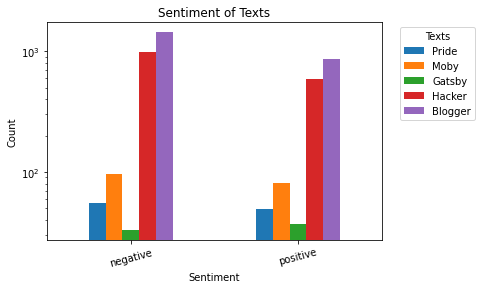

In [324]:
ax = df_all3.plot.bar(x='sentiment_category', logy=True,rot=15)

#plt.xticks('word')
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title= "Texts")
plt.title("Sentiment of Texts")

pridy = df_both.reset_index() 
moby = df_both.reset_index() 
gatsy = df_both.reset_index()
hacky = df_both.reset_index()
blogy =df_both.reset_index()

valss = pd.concat([ pridy.Pride,moby.Moby,gatsy.Gatsby,hacky.Hacker, blogy.Blog], axis=1)
vals =valss.unstack().reset_index(level=[0,1], drop=True)



for idx, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/3.5,
            height + height*.02,
            vals[idx],
            ha="center")

In [309]:
df_all3.insert(0, "sentiment_category", ['negative','positive'], True)

In [310]:
df_all3

,sentiment_category,Pride,Moby,Gatsby,Hacker,Blogger
sentiment_category,,,,,,
negative,negative,55,96,33,993,1440
positive,positive,49,81,37,591,872
